# Assignment 4: Neo4j Graph Database (KK3789)

---
## Details

#### Step 1: Download and Install Neo4j Desktop
Refer to our [Neo4j Installation Guide](https://courseworks2.columbia.edu/courses/214510/pages/installation-guide-neo4j-graph-database)


#### Step 2: Populate Your Graph Database

Refer to [Module 8 Class Exercise](https://courseworks2.columbia.edu/courses/214510/files/22738549?wrap=1) & [Neo4j Cypher Manual](https://neo4j.com/docs/cypher-manual/current/introduction/)

- Create a new Jupyter Notebook and complete the following steps in that notebook
- **!pip install neo4j** package
- import data from the [companies.csv](https://courseworks2.columbia.edu/courses/214510/files/22738554?wrap=1) file or populate it from the records table below
- establish node relationships that may be necessary to answer the questions in Step 3
- **Note**: you can also populate and visualize the nodes and relations using Cypher commands from inside Neo4j Desktop

#### Step 3: Build and run Python Cypher queries against the Neo4j Database to answer the following questions:
- Which companies are located in the state of California (via 2nd degree relation)?
- Which companies have been founded in the last quarter of the 20th century [1975-2000]? 
- What is the average annual revenue for all companies in the USA?
- Which companies are headquartered in Japan (via 3rd degree relation)?
- What is the total number of employees of all companies in the USA and Germany (via 3rd degree relation)?

**Your final submission should be a Jupyter Notebook file (.ipynb and .html) that shows the creation of nodes and relationships in Neo4j (Step 2) and answers queries for questions 1-5 (Step 3) with the retrieved and printed output.**

In [3]:
import os
import urllib
from neo4j import GraphDatabase
from PIL import Image
import pandas as pd
from tabulate import tabulate

## Database Connection:
I'm using docker container and this is connect information and to check connection status.
- **uri** `"bolt://apan-neo4j:7687"` → Database URI  
- **username** `"neo4j"` → Database username   
- **password** `"password"` → Database password

In [4]:
# Connection details
username = "neo4j"
password = "password"
uri = "bolt://apan-neo4j:7687"

try:
    # Create a driver instance
    driver = GraphDatabase.driver(uri, auth=(username, password))
    with driver.session() as session:
        result = session.run("RETURN 'Connection successful!' AS message")
        for record in result:
            print(record["message"])
        
except Exception as e:
    print(f"Failed to connect to Neo4j: {e}")


Connection successful!


---

# Insertion data into Neo4J
When I use "CREATE" for relationship, it creates a duplicated "edges" by adding multiple times. \
So I used "MERGE" to keep the single edges.
And I used dataframe to count records and insert them one by one.

In [4]:
driver = GraphDatabase.driver(uri, auth=(username, password))
session = driver.session()

In [5]:
# Neo4j connection details
uri = "bolt://apan-neo4j:7687/"  # Use the mapped port from docker-compose.yml
username = "neo4j"
password = "password"

# Path to the CSV file
datapath = os.path.abspath("companies.csv")
print(f"Loading data from: {datapath}")

# Load CSV into a Pandas DataFrame
try:
    df = pd.read_csv(datapath)
    print(f"{len(df)} records loaded from CSV successfully!")
except Exception as e:
    print(f"Error loading CSV: {e}")
    exit()

# Connect to Neo4j and insert data
def insert_data_to_neo4j(session, row):
    query = """
    CREATE (company:Company {
        name: $company,
        employees: $employees,
        founded: $founded,
        year: $founded,
        revenue: $revenue
    })
    MERGE (city:City {name: $city})
    MERGE (state:State {name: $state})
    MERGE (country:Country {name: $country})
    MERGE (company)-[:HEADQUARTERED_IN]->(city)
    MERGE (city)-[:LOCATED_IN]->(state)
    MERGE (city)-[:CITY_OF]->(country)
    MERGE (state)-[:PART_OF]->(country)
    """
    session.run(query, 
           company=row['company'], 
           employees=int(row['employees']) if not pd.isna(row['employees']) else None,
           founded=int(row['founded']) if not pd.isna(row['founded']) else None,
           revenue=float(row['revenue']) if not pd.isna(row['revenue']) else None,
           city=row['city'], 
           state=row['state'] if not pd.isna(row['state']) else "NULL",
           country=row['country'])

try:
    driver = GraphDatabase.driver(uri, auth=(username, password))
    with driver.session() as session:
        for _, row in df.iterrows():
            session.execute_write(insert_data_to_neo4j, row)
        print("All companies have been imported from the DataFrame!")
except Exception as e:
    print(f"Error: {e}")

Loading data from: /home/jovyan/companies.csv
15 records loaded from CSV successfully!


### Data in CSV

In [12]:
df

,company,city,state,country,description,employees,founded,revenue
0,Apple,Cupertino,California,USA,American multinational technology company that...,164000,1976,394.33
1,Microsoft,Redmond,Washington,USA,American multinational technology company that...,221000,1975,198.27
2,Amazon,Seattle,Washington,USA,American multinational technology company whic...,1541000,1994,513.98
3,Alphabet,Mountain View,California,USA,American multinational technology company that...,190234,1998,282.84
4,Alibaba Group,Hangzhou,Zhejiang,China,Chinese multinational technology company speci...,239740,1999,134.57
5,Sony Group,Tokyo,Tokyo,Japan,Japanese multinational conglomerate that manuf...,108900,1946,88.30
6,Samsung Electronics,Suwon,Gyeonggi,South Korea,South Korean multinational electronics company...,266673,1969,245.70
7,Mercedes-Benz Group,Stuttgart,Baden-Wurttemberg,Germany,German multinational automotive corporation th...,172425,1926,153.95
8,Tesla,Austin,Texas,USA,American company that designs and manufactures...,127855,2003,81.46
9,British Petroleum,London,England,UK,British multinational oil and gas company invo...,65900,1909,248.89


### Check Companies in Neo4j

In [52]:
from neo4j import GraphDatabase

# Neo4j connection details
uri = "bolt://apan-neo4j:7687/"  # Use the mapped port from docker-compose.yml
username = "neo4j"
password = "password"  # Replace with your actual password

# Connect to Neo4j
driver = GraphDatabase.driver(uri, auth=(username, password))


with driver.session() as session:
    # Query to check if companies were loaded
    result = session.run("""
    MATCH (c:Company)
    RETURN c.name as Company_Name, c.employees as Employees, c.founded as Founded, c.revenue as Revenue
    ORDER BY c.name""")
    records = list(result)
    print(f"Companies from query : {len(records)}")
    data = [record.data() for record in records]
    print(tabulate(data, headers="keys", tablefmt="grid"))


Companies from query : 15
+--------------------------------------+-------------+-----------+-----------+
| Company_Name                         |   Employees |   Founded |   Revenue |
+======================================+=============+===========+===========+
| Alibaba Group                        |      239740 |      1999 |    134.57 |
+--------------------------------------+-------------+-----------+-----------+
| Allianz                              |      155411 |      1890 |    161.44 |
+--------------------------------------+-------------+-----------+-----------+
| Alphabet                             |      190234 |      1998 |    282.84 |
+--------------------------------------+-------------+-----------+-----------+
| Amazon                               |     1541000 |      1994 |    513.98 |
+--------------------------------------+-------------+-----------+-----------+
| Apple                                |      164000 |      1976 |    394.33 |
+-------------------------

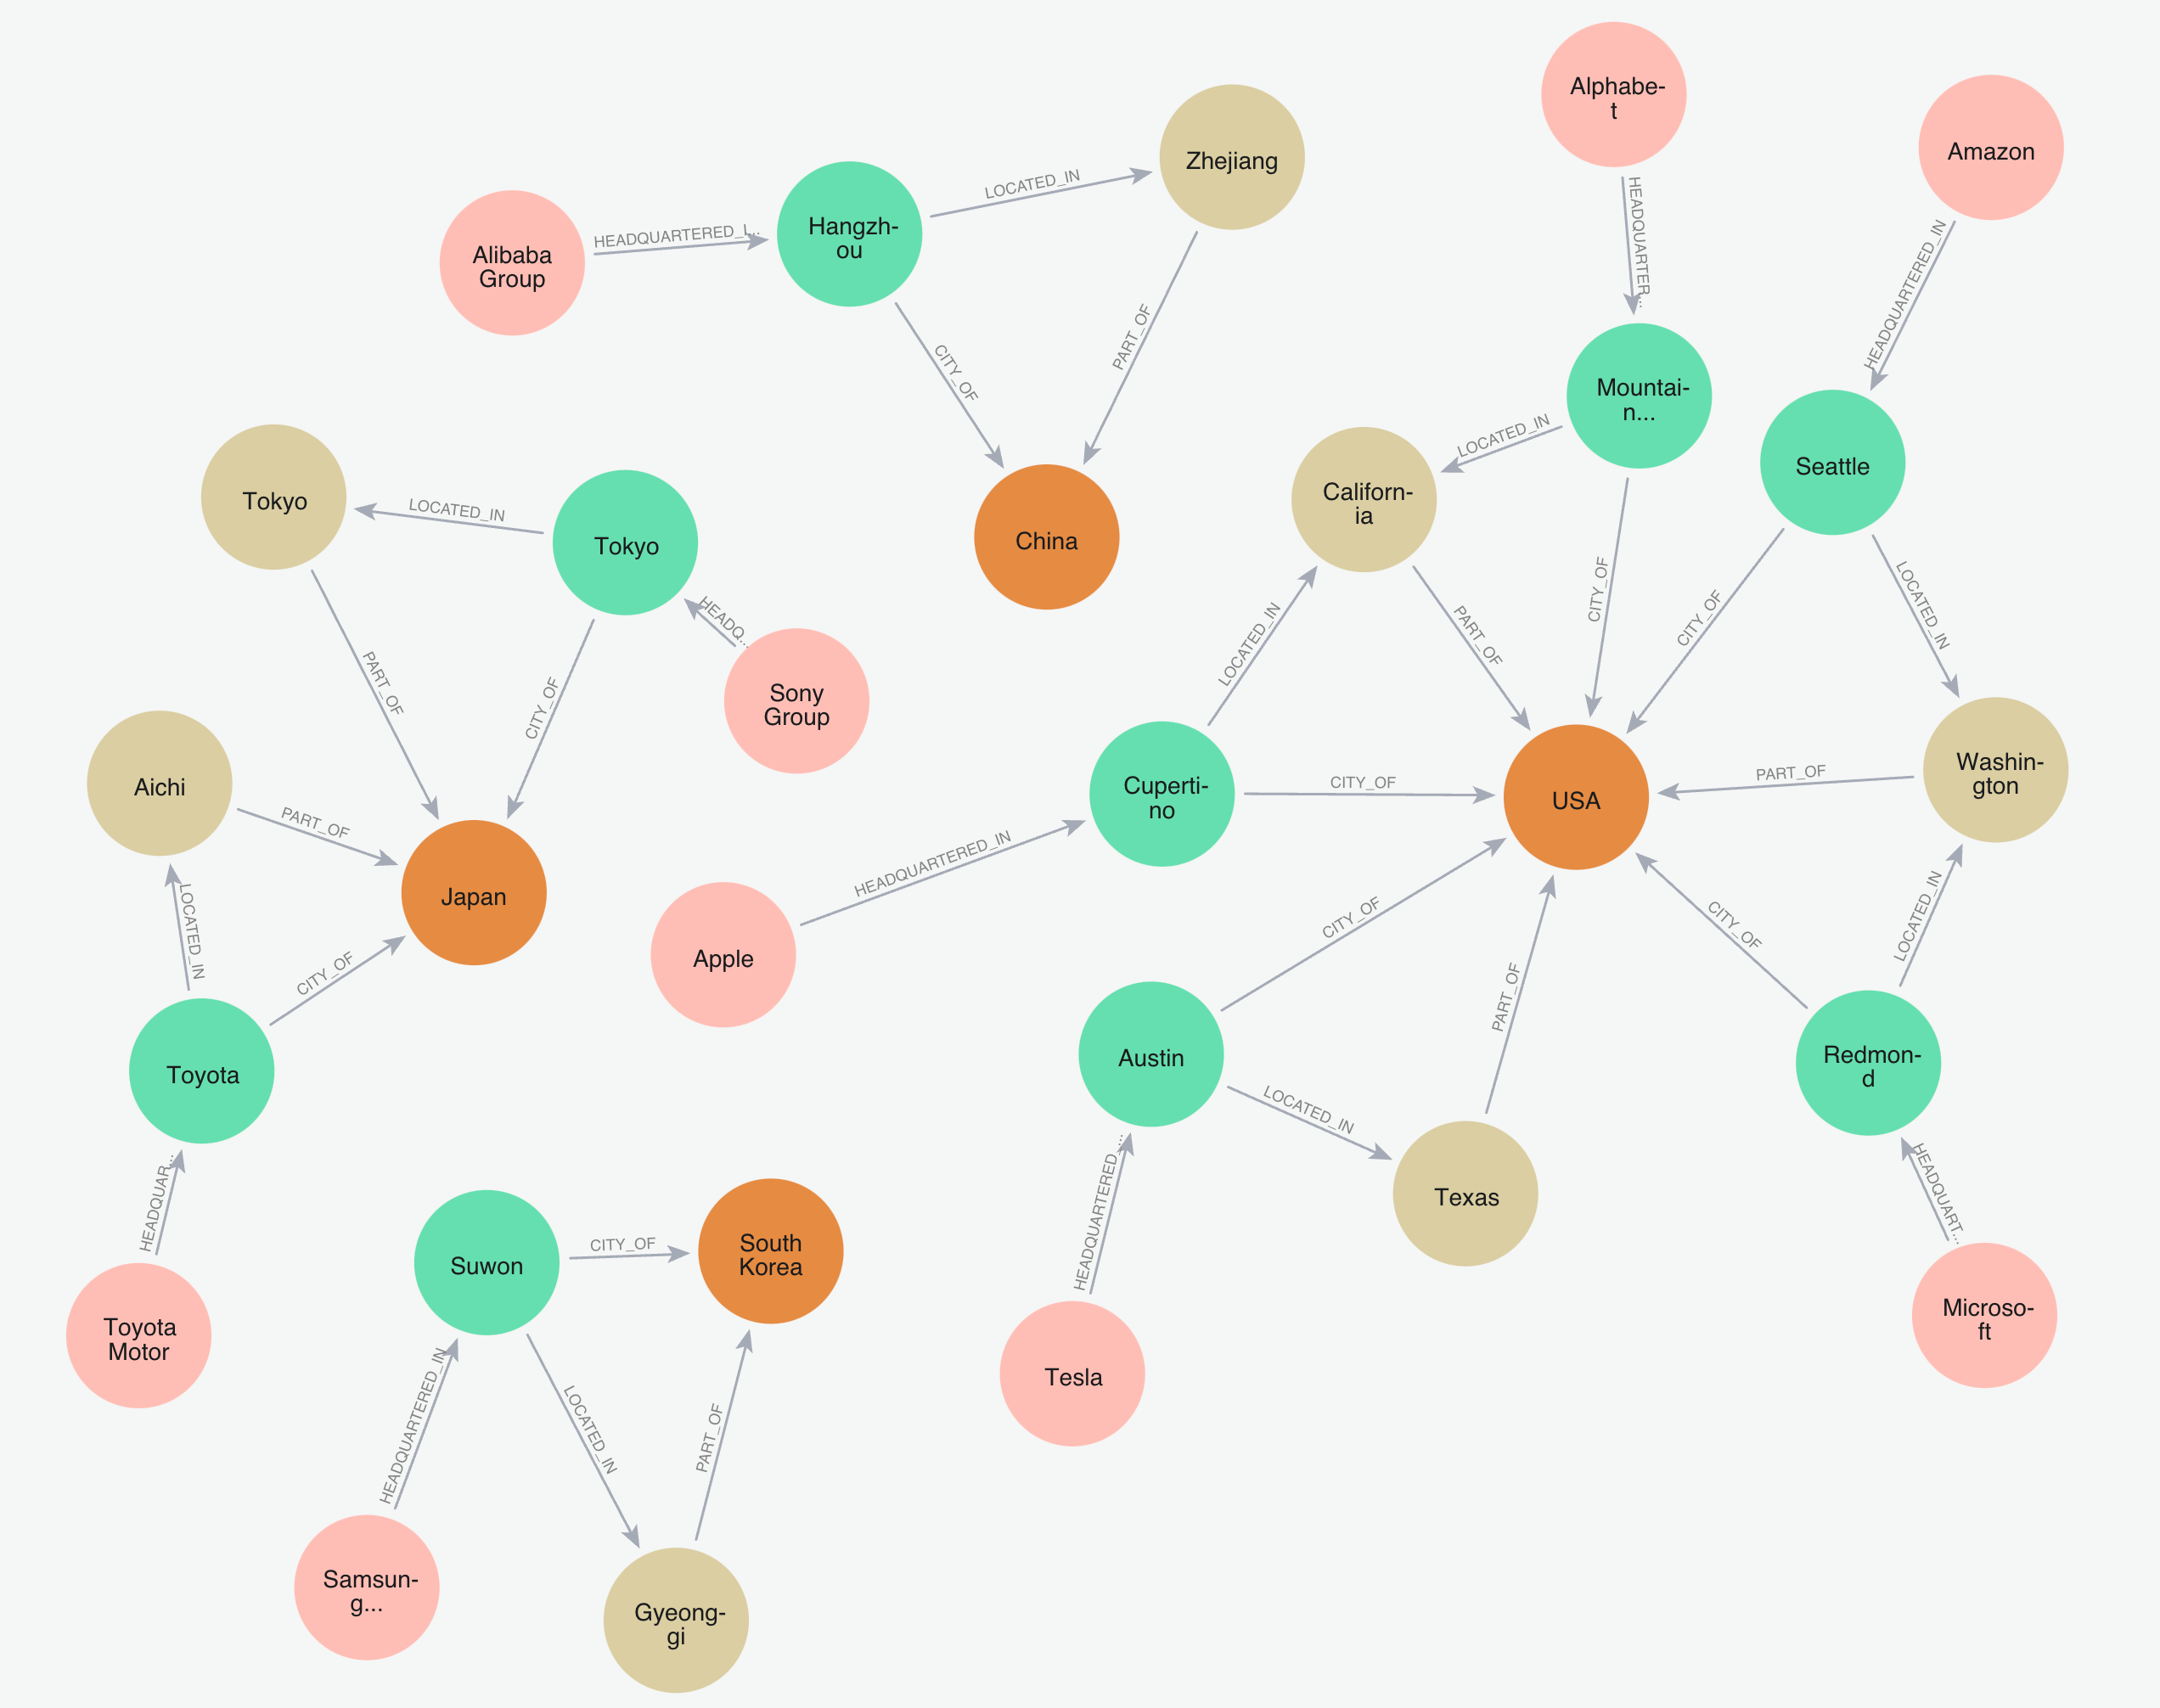

In [19]:
img = Image.open('Neo4jMap.png')
img

# Tasks


Which companies are located in the state of California (via 2nd degree relation)? \
Which companies have been founded in the last quarter of the 20th century [1975-2000]? \
What is the average annual revenue for all companies in the USA? \
Which companies are headquartered in Japan (via 3rd degree relation)? \
What is the total number of employees of all companies in the USA and Germany (via 3rd degree relation)?

### 1. Which companies are located in the state of California (via 2nd degree relation)?

In this part, for 2nd degree relationships, I used relationships from company to city and city to state. 


In [45]:
driver = GraphDatabase.driver(uri, auth=(username, password))
session = driver.session()

query_1 = """
MATCH (c:Company)-[:HEADQUARTERED_IN]->(city:City)-[:LOCATED_IN]->(s:State {name: 'California'})
RETURN c.name AS Company, city.name as City, s.name as State
"""
companies_in_california = session.run(query_1)

records = list(companies_in_california)
print(f"Companies from query : {len(records)}")
data = [record.data() for record in records]
print(tabulate(data, headers="keys", tablefmt="grid"))

session.close()

Companies from query : 2
+-----------+---------------+------------+
| Company   | City          | State      |
+===========+===============+============+
| Alphabet  | Mountain View | California |
+-----------+---------------+------------+
| Apple     | Cupertino     | California |
+-----------+---------------+------------+


### 2. Which companies have been founded in the last quarter of the 20th century [1975-2000]?

In this part, I filtered companies founded between 1976 and 2000 and then sorted by founded year.


In [46]:
driver = GraphDatabase.driver(uri, auth=(username, password))
session = driver.session()

query_2 = """
MATCH (c:Company)
WHERE c.founded > 1975 AND c.founded <= 2000
RETURN c.name AS company, c.founded AS founded_year
ORDER BY c.founded
"""
companies_founded_last_quarter = session.run(query_2)

records = list(companies_founded_last_quarter)
print(f"Companies founded between 1976 and 2000 : {len(records)}")
data = [record.data() for record in records]
print(tabulate(data, headers="keys", tablefmt="grid"))

session.close()

Companies founded between 1976 and 2000 : 5
+--------------------------------------+----------------+
| company                              |   founded_year |
+======================================+================+
| Apple                                |           1976 |
+--------------------------------------+----------------+
| China National Petroleum Corporation |           1988 |
+--------------------------------------+----------------+
| Amazon                               |           1994 |
+--------------------------------------+----------------+
| Alphabet                             |           1998 |
+--------------------------------------+----------------+
| Alibaba Group                        |           1999 |
+--------------------------------------+----------------+


### 3. What is the average annual revenue for all companies in the USA?

In this part, filtered with "USA" country name and used avg to calculate average annual revenue


In [47]:
driver = GraphDatabase.driver(uri, auth=(username, password))
session = driver.session()

query_3 = """
MATCH (c:Company)-[:HEADQUARTERED_IN]->(:City)-[:CITY_OF]->(co:Country {name: 'USA'})
RETURN avg(c.revenue) AS average_revenue
"""
average_revenue_usa = session.run(query_3)

records = list(average_revenue_usa)

data = [record.data() for record in records]
print(tabulate(data, headers="keys", tablefmt="grid"))


# To get companies in the USA
query_3_1 = """
MATCH (c:Company)-[:HEADQUARTERED_IN]->(city:City)-[:CITY_OF]->(co:Country {name: 'USA'})
RETURN c.name AS Company, city.name as City, co.name as Country, c.revenue as Revenue
ORDER BY c.name
"""
companies_in_usa = session.run(query_3_1)

records = list(companies_in_usa)
print(f"\nCompanies in the USA : {len(records)}")
data = [record.data() for record in records]
print(tabulate(data, headers="keys", tablefmt="grid"))

session.close()

+-------------------+
|   average_revenue |
+===================+
|           294.176 |
+-------------------+

Companies in the USA : 5
+-----------+---------------+-----------+-----------+
| Company   | City          | Country   |   Revenue |
+===========+===============+===========+===========+
| Alphabet  | Mountain View | USA       |    282.84 |
+-----------+---------------+-----------+-----------+
| Amazon    | Seattle       | USA       |    513.98 |
+-----------+---------------+-----------+-----------+
| Apple     | Cupertino     | USA       |    394.33 |
+-----------+---------------+-----------+-----------+
| Microsoft | Redmond       | USA       |    198.27 |
+-----------+---------------+-----------+-----------+
| Tesla     | Austin        | USA       |     81.46 |
+-----------+---------------+-----------+-----------+


### 4. Which companies are headquartered in Japan (via 3rd degree relation)?

In this part, for 3rd degree relationships, I used relationships from company to city and city to state and the state to country. \
But Toyota Motor has wrong city name.

In [48]:
driver = GraphDatabase.driver(uri, auth=(username, password))
session = driver.session()

query_4 = """
MATCH (c:Company)-[:HEADQUARTERED_IN]->(city:City)-[:LOCATED_IN]->(s:State)-[:PART_OF]->(co:Country {name: 'Japan'})
RETURN c.name AS Company, city.name as City, s.name as State, co.name as Country
"""
companies_in_japan = session.run(query_4)

records = list(companies_in_japan)
print(f"\nCompanies in Japan : {len(records)}")
data = [record.data() for record in records]
print(tabulate(data, headers="keys", tablefmt="grid"))

session.close()


Companies in Japan : 2
+--------------+--------+---------+-----------+
| Company      | City   | State   | Country   |
+==============+========+=========+===========+
| Toyota Motor | Toyota | Aichi   | Japan     |
+--------------+--------+---------+-----------+
| Sony Group   | Tokyo  | Tokyo   | Japan     |
+--------------+--------+---------+-----------+


### 5. What is the total number of employees of all companies in the USA and Germany (via 3rd degree relation)?

In this part, for 3rd degree relationships, I used relationships from company to city and city to state and the state to country. \
and used sum to calculate total employees


In [51]:
driver = GraphDatabase.driver(uri, auth=(username, password))
session = driver.session()

query_5 = """
MATCH (c:Company)-[:HEADQUARTERED_IN]->(:City)-[:LOCATED_IN]->(:State)-[:PART_OF]->(co:Country)
WHERE co.name IN ['USA', 'Germany']
RETURN sum(c.employees) AS total_employees
"""
total_employees_usa_germany = session.run(query_5)

records = list(total_employees_usa_germany)
data = [record.data() for record in records]
print(tabulate(data, headers="keys", tablefmt="grid"))

# To get companies in the USA and Germany
query_5_1 = """
MATCH (c:Company)-[:HEADQUARTERED_IN]->(city:City)-[:LOCATED_IN]->(s:State)-[:PART_OF]->(co:Country)
WHERE co.name IN ['USA', 'Germany']
RETURN c.name AS Company, city.name as City, s.name as State, co.name as Country, c.employees AS Employees
ORDER BY c.name
"""
companies_in_usa_and_germany = session.run(query_5_1)

records = list(companies_in_usa_and_germany)
print(f"\nCompanies in USA and Germany : {len(records)}")
data = [record.data() for record in records]
print(tabulate(data, headers="keys", tablefmt="grid"))
session.close()

+-------------------+
|   total_employees |
+===================+
|           2571925 |
+-------------------+

Companies in USA and Germany : 7
+---------------------+---------------+-------------------+-----------+-------------+
| Company             | City          | State             | Country   |   Employees |
+=====================+===============+===================+===========+=============+
| Allianz             | Munich        | Bavaria           | Germany   |      155411 |
+---------------------+---------------+-------------------+-----------+-------------+
| Alphabet            | Mountain View | California        | USA       |      190234 |
+---------------------+---------------+-------------------+-----------+-------------+
| Amazon              | Seattle       | Washington        | USA       |     1541000 |
+---------------------+---------------+-------------------+-----------+-------------+
| Apple               | Cupertino     | California        | USA       |      16400

In [40]:
driver = GraphDatabase.driver(uri, auth=(username, password))
session = driver.session()
query = ("MATCH (n) DETACH DELETE n")
result = session.run(query)
print("All Nodes and relationships are deleted!")
session.close()

All Nodes and relationships are deleted!


# THANK YOU !!